In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Datasets/train_E6oV3lV.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Datasets/test_tweets_anuFYb8.csv')

In [ ]:
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
train_data.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
train_data[train_data['label']==1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


In [ ]:
# check target value imbalance
train_data["label"].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

-- The class is imbalance

In [ ]:
train_data.shape


(31962, 3)

In [ ]:
train_data.duplicated().sum()

0

In [ ]:
train_data.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add('user')

def plot_wordcloud(tweets, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(tweets)
    plt.figure(figsize=(14, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontdict={'fontsize': 20})
    plt.show()

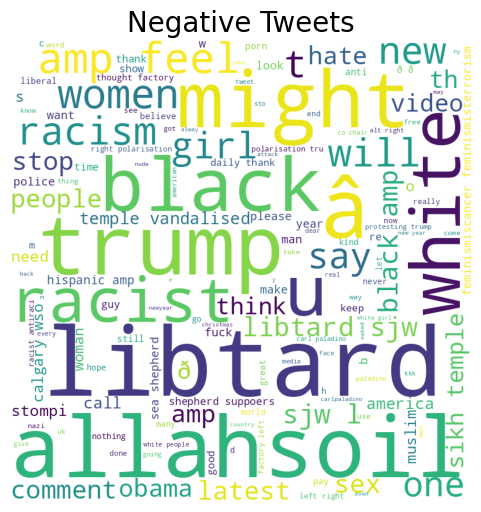

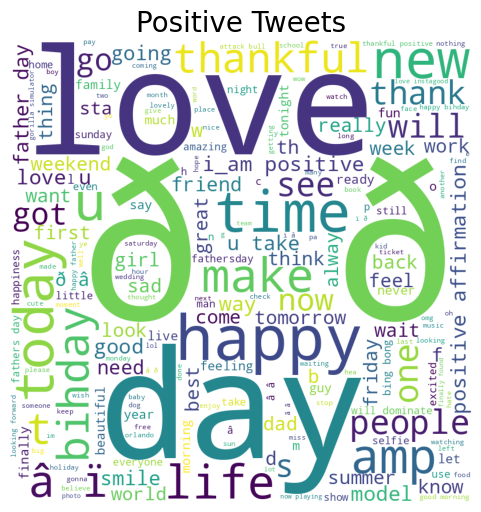

In [ ]:
negative_tweets = train_data['tweet'][train_data['label'] == 1].to_string()
positive_tweets = train_data['tweet'][train_data['label'] == 0].to_string()

plot_wordcloud(negative_tweets, 'Negative Tweets')
plot_wordcloud(positive_tweets, 'Positive Tweets')

In [ ]:
train_df_fe = train_data.copy()
train_df_fe['tweet_length'] = train_df_fe['tweet'].str.len()
train_df_fe['num_hashtags'] = train_df_fe['tweet'].str.count('#')
train_df_fe['num_exclamation_marks'] = train_df_fe['tweet'].str.count('!')
train_df_fe['num_question_marks'] = train_df_fe['tweet'].str.count('\?')
train_df_fe['total_tags'] = train_df_fe['tweet'].str.count('@')
train_df_fe['num_punctuations'] = train_df_fe['tweet'].str.count('[.,:;]')
train_df_fe['num_words'] = train_df_fe['tweet'].apply(lambda x: len(x.split()))
train_df_fe.head()

,id,label,tweet,tweet_length,num_hashtags,num_exclamation_marks,num_question_marks,total_tags,num_punctuations,num_words
0,1,0,@user when a father is dysfunctional and is s...,102,1,0,0,1,1,18
1,2,0,@user @user thanks for #lyft credit i can't us...,122,3,0,0,2,1,19
2,3,0,bihday your majesty,21,0,0,0,0,0,3
3,4,0,#model i love u take with u all the time in ...,86,1,3,0,0,0,14
4,5,0,factsguide: society now #motivation,39,1,0,0,0,1,4


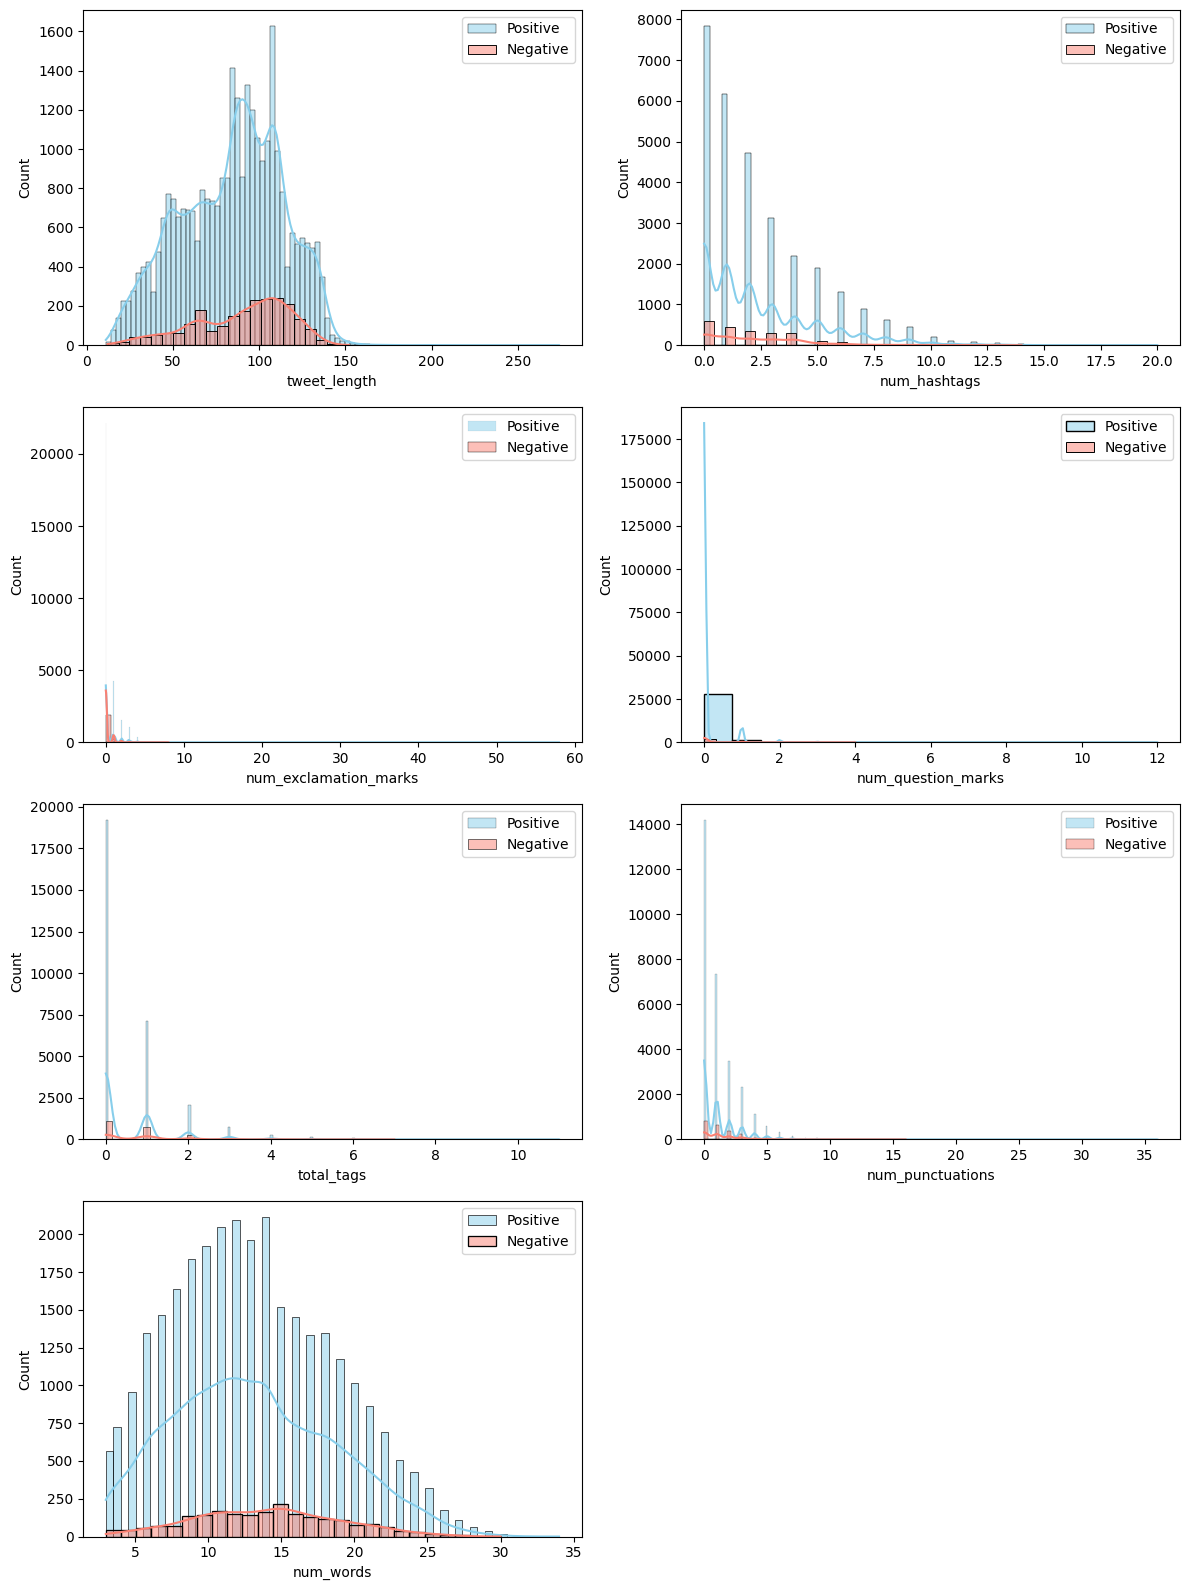

In [ ]:
features = ['tweet_length', 'num_hashtags', 'num_exclamation_marks', 'num_question_marks', 'total_tags', 'num_punctuations', 'num_words']

# Check if train_df_fe has the expected columns
if set(features).issubset(train_df_fe.columns):
    plt.figure(figsize=(12, 16))
    colors = ['skyblue', 'salmon']

    for i, feature in enumerate(features, 1):
        plt.subplot(4, 2, i)
        sns.histplot(train_df_fe[train_df_fe.label == 0][feature], label='Positive', kde=True, color=colors[0])
        sns.histplot(train_df_fe[train_df_fe.label == 1][feature], label='Negative', kde=True, color=colors[1])
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
X = train_data.drop(columns=['label'])
y = train_data['label']
test = test_data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
def tokenize_and_clean(text):
    # Convert text to lowercase
    lowered = text.lower()

    # Remove '@user'
    cleaned = re.sub('@user', '', lowered)

    # Tokenize the text
    tokens = word_tokenize(cleaned)

    # Filter out non-alphanumeric tokens
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]

    # Stem the tokens
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]

    return stems

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(X_train['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(X_test['tweet'])
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])
test_tweets_tfidf = tfidf_vectorizer.transform(test['tweet'])

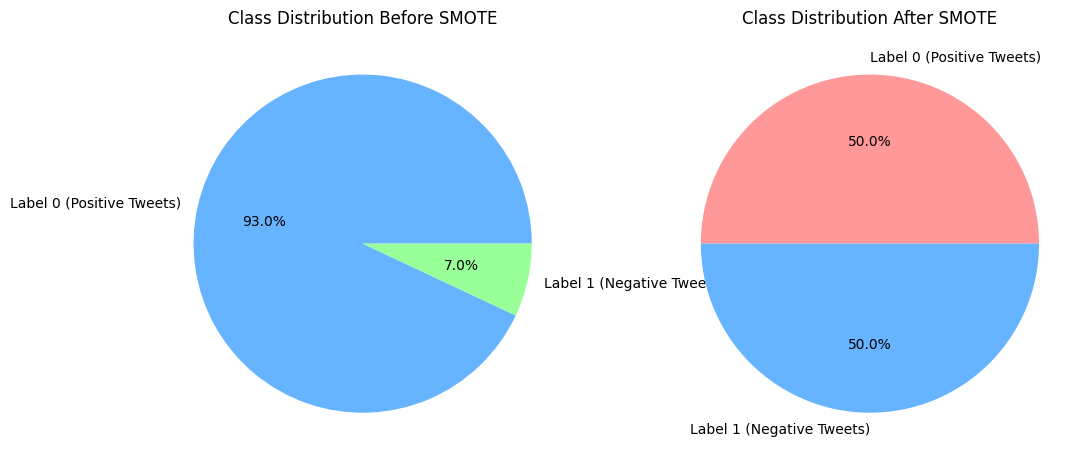

In [ ]:
plt.figure(figsize=(12, 6))

# Colors for the pie charts
colors_before_smote = ['#66b3ff', '#99ff99']
colors_after_smote = ['#ff9999', '#66b3ff']

labels = ['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)']

# Plotting before SMOTE
plt.subplot(1, 2, 1)
plt.pie(y_train.value_counts(), labels=labels, autopct='%0.1f%%', colors=colors_before_smote)
plt.title('Class Distribution Before SMOTE')

# SMOTE to deal with the class imbalance
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tweets_tfidf, y_train.values)

# Plotting after SMOTE
plt.subplot(1, 2, 2)
plt.pie(pd.value_counts(y_train_smote), labels=labels, autopct='%0.1f%%', colors=colors_after_smote)
plt.title('Class Distribution After SMOTE')
plt.show()

In [ ]:
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: Accuracy={acc}, F1-Score={f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Validation Scores: Accuracy={acc}, F1-Score={f1}')

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    training_scores(y_train, y_train_pred)
    validation_scores(y_test, y_test_pred)

In [ ]:
lr = LogisticRegression()
train_and_evaluate(lr, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.975, F1-Score=0.975
Validation Scores: Accuracy=0.926, F1-Score=0.605


In [ ]:
rf = RandomForestClassifier()
train_and_evaluate(rf, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=1.0, F1-Score=1.0
Validation Scores: Accuracy=0.958, F1-Score=0.668


In [ ]:
mnb = MultinomialNB()
train_and_evaluate(mnb, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.967, F1-Score=0.968
Validation Scores: Accuracy=0.923, F1-Score=0.615
